In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# alternate loading system


In [2]:
imageList = tf.data.Dataset.list_files(os.path.join('data', '*.png'), 
                                   shuffle = False)
textList = tf.data.Dataset.list_files(os.path.join('data', '*.txt'),
                                      shuffle = False)


imagecount = len(imageList)
print(imagecount)
textcount = len(textList)
print(textcount)

2524
2524


In [3]:
for f in imageList.take(5):
  print(f.numpy())


b'data\\002b6c17-1901-11ee-a632-001a7dda7115.png'
b'data\\004a045c-1901-11ee-bbb3-001a7dda7115.png'
b'data\\0068d956-1901-11ee-a39c-001a7dda7115.png'
b'data\\0087903e-1901-11ee-9b96-001a7dda7115.png'
b'data\\00c2f316-1901-11ee-aa05-001a7dda7115.png'


In [4]:
def preprocess(filepath):
    # this is the function that will process all the images that are in the image list for basic conversion

    #read image
    img = tf.io.read_file(filepath)
    #load image
    img = tf.io.decode_png(img, channels=3)

    img = tf.image.resize(img, [586, 826])
    #scaled the image to be 0-1
    img = img / 255

    img = tf.image.central_crop(image=img, central_fraction=0.80)

    #img = tf.image.rgb_to_grayscale(img)

    #img = tf.expand_dims(img, axis=0)


    return img

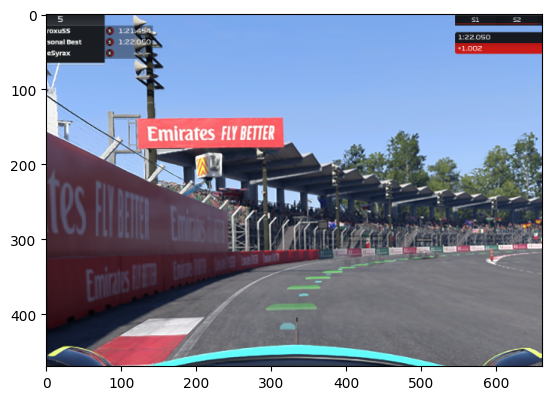

In [5]:
imageList = imageList.map(preprocess)
plt.imshow(imageList.as_numpy_iterator().next(), cmap='gray')


In [6]:
def preprocess_text(filepath):

    key = tf.io.read_file(filepath)

    if key == 'up arrow\r\n':
        return [1,0,0,0]
    if key == 'down arrow\r\n':
        return [0,1,0,0]
    if key == 'left arrow\r\n':
        return [0,0,1,0]
    if key == 'right arrow\r\n':
        return [0,0,0,1]
    if key == 'left arrow,up arrow\r\n':
        return [1,0,1,0]
    if key == 'left arrow,down arrow\r\n':
        return [0,1,1,0]
    if key == 'right arrow,up arrow\r\n':
        return [1,0,0,1]
    if key == 'right arrow,down arrow\r\n':
        return [0,1,0,1]
    else:
        return [0,0,0,0]
    return key 

In [7]:
def wrap_array(x1,x2,x3,x4):
    return tf.expand_dims([x1,x2,x3,x4], axis = 0)

In [8]:
textList = textList.map(lambda x: tf.py_function(preprocess_text, [x], ([tf.int16, tf.int16, tf.int16, tf.int16,])))
textList = textList.map(wrap_array)


In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Input

normalization_layer = tf.keras.layers.Rescaling(1./255)




In [10]:
val_size = int(0.2 * imagecount)

train_image = imageList.skip(val_size)
train_text = textList.skip(val_size)
val_image = imageList.take(val_size)
val_text = textList.take(val_size)

print(len(val_image), len(train_image))

504 2020


In [11]:
train_ds = tf.data.Dataset.zip((train_image, train_text))
val_ds = tf.data.Dataset.zip((val_image, val_text))

#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (470, 662, 3)
Label:  [[1 0 1 0]]


In [12]:
def unwrap(x, y):
    return x, tf.squeeze(y)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(8)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  ds = ds.map(unwrap)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (8, 470, 662, 3)
Label:  [[1 0 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]


In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(label_batch[i].numpy())
  plt.axis("off")


In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

In [14]:
#tf.reshape(train_ds, [586, 826])

model = Sequential()

print(imageList.as_numpy_iterator().next().shape)

#model.add(keras.Input(shape=((586, 826, 3))))

model.add(Conv2D(64,  #filters
                  5,  #kernel size
                  strides = (3,3),   #reducing the compression so its not 400 million parameters lkmfaoooo
                activation = 'relu',  #activation type
                input_shape =((470, 662, 3)
                )))  #input shape (batch, shape as seen above)#

model.add(BatchNormalization())

model.add(MaxPooling2D())

model.add(Conv2D(128, 4, 
                 strides = (3,3),
                   activation='relu'))

model.add(BatchNormalization())


model.add(Conv2D(128, 3, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())

model.add(MaxPooling2D())

model.add(Conv2D(256, 2, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())



model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(4, activation='softmax'))

(470, 662, 3)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 220, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 156, 220, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 110, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 36, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 25, 36, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
#train_iterator = tf.compat.v1.data.make_one_shot_iterator(
#    train_ds
#)

#val_iterator = tf.compat.v1.data.make_one_shot_iterator(
#    val_ds
#)


In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [ ]:
#epochs = 10
#steps_per_epoch = len(imageList) // 8

#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    
#    for step in range(steps_per_epoch):
#        # Get a batch of data and labels from the training iterator
#        data_batch, label_batch = train_iterator.get_next()
#        
#        # Train your model with the batch
#        model.train_on_batch(data_batch, label_batch)

    # Perform validation at the end of each epoch
#    val_loss, val_accuracy = model.evaluate(val_iterator)
#    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

In [17]:
model.fit(train_ds, validation_data=val_ds, epochs=25,
          # steps_per_epoch=(250)
          )


Epoch 1/25
253/253 [==============================] - 71s 252ms/step - loss: 1.7080 - categorical_accuracy: 0.6119 - val_loss: 1.7083 - val_categorical_accuracy: 0.6409
Epoch 2/25
253/253 [==============================] - 64s 255ms/step - loss: 1.6560 - categorical_accuracy: 0.6886 - val_loss: 1.6404 - val_categorical_accuracy: 0.7341
Epoch 3/25
253/253 [==============================] - 63s 250ms/step - loss: 1.6316 - categorical_accuracy: 0.7351 - val_loss: 1.6534 - val_categorical_accuracy: 0.7679
Epoch 4/25
253/253 [==============================] - 63s 247ms/step - loss: 1.6307 - categorical_accuracy: 0.7356 - val_loss: 1.7605 - val_categorical_accuracy: 0.4960
Epoch 5/25
253/253 [==============================] - 60s 235ms/step - loss: 1.6193 - categorical_accuracy: 0.7470 - val_loss: 1.6236 - val_categorical_accuracy: 0.7560
Epoch 6/25
253/253 [==============================] - 59s 230ms/step - loss: 1.6095 - categorical_accuracy: 0.7371 - val_loss: 1.6078 - val_categorical_acc

KeyboardInterrupt: 

In [19]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"test accuracy -> {test_acc}, test loss -> {test_loss}")


63/63 [==============================] - 4s 58ms/step - loss: 1.6602 - categorical_accuracy: 0.6329
test accuracy -> 0.6329365372657776, test loss -> 1.6601951122283936


## SAVING THE MODEL NOW

In [22]:
import tempfile

import cv2

In [ ]:
#MODEL_DIR = tempfile.gettempdir()
#version = 1
#export_path = os.path.join(MODEL_DIR, str(version))
#print(f'export path = {export_path}')


In [ ]:
#tf.keras.models.save_model(
#    model,
#    export_path,
#    overwrite=True,
#    include_optimizer=True,
#    save_format=None,
#    signatures=None,
#    options=None
#)

#print('\nSaved model:')

In [ ]:
#echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
#curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
#{SUDO_IF_NEEDED} apt update

In [20]:
model.save('modeltype1.model')

INFO:tensorflow:Assets written to: modeltype1.model\assets


INFO:tensorflow:Assets written to: modeltype1.model\assets


In [23]:
image_path = 'data/fa4e78bb-1900-11ee-bbd7-001a7dda7115.png'
img = cv2.imread(image_path)
img = cv2.resize(img, (662, 470))  # Resize to (662, 470) to match the model's input shape
img = img / 255.0  # Normalize the pixel values to the range [0, 1]





# Make a prediction
for x in imageList:
    prediction = model.predict(tf.convert_to_tensor([x]))  # Convert the NumPy array to a TensorFlow tensor
    round_preds = np.around(prediction)
    round_preds.squeeze()
    if not np.all(round_preds == [[1., 0., 0., 0.]]):
        print(round_preds)


1/1 [==============================] - 0s 155ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 23ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 24ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 21ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 23ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 24ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 21ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 22ms/

KeyboardInterrupt: 

In [ ]:
round_preds